In [28]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import numpy as np
import re
from string import ascii_uppercase, ascii_lowercase
from math import sqrt
import time
import warnings
import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type

from colabfold.colabfold import plot_protein
from pathlib import Path

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
print(torch.cuda.is_available())

True


In [29]:
import jax
import jax.numpy as jnp
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from colabdesign import mk_af_model

import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import pickle
from tqdm.notebook import tqdm
import glob

from colabdesign.af.alphafold.common import protein
from colabdesign.shared.protein import renum_pdb_str
from colabdesign.af.alphafold.common import residue_constants

from soluble_tools import *
print('worked')

worked


In [30]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [31]:
import os
from colabdesign import mk_afdesign_model, clear_mem
import numpy as np

In [75]:

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 5, 1, 0, bias=False),
            nn.LeakyReLU(),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 1, bias=False),
            nn.LeakyReLU(),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 4, ngf * 2, (4,3), (1,2), (0,1), bias=False),
            nn.LeakyReLU(),
            # state size. (ngf*2) x 10 x 20
            nn.ConvTranspose2d( ngf * 2, ngf, (4,3), (1,2), (0,1), bias=False),
            nn.LeakyReLU(),
            # state size. (ngf) x 20 x 40
            nn.ConvTranspose2d( ngf, nc, (4,3), (1,2), (0,1), bias=False),
            # state size. (nc) x 20 x 80
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)


# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

# Initialize BCELoss function
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(netG.parameters(), lr=lr, weight_decay=0)
#optimizerG = torch.optim.Adagrad(netG.parameters(), lr=0.01)

Random Seed:  999
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.01)
    (8): ConvTranspose2d(64, 1, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (9): Tanh()
  )
)


In [41]:
aa = 'A R N D C E Q G H I L K M F P S T W Y V'
aminoacid_list = aa.split(' ')
a_dict={}
for i, aaa in enumerate(aminoacid_list):
  a_dict[aaa]=i


def numpy_to_seq(array, seq_len, oligomer=1):
  sequence = []
  receptor = ''
  array = array.cpu().detach().numpy()
  for i in array:
    seq=''
    array_n = i[0]
    for i in array_n.T:
      z = np.argmax(i)
      seq+=aminoacid_list[z]
    seq = seq[:seq_len]
    sequence.append(seq)
  return sequence

In [42]:
def seq_to_tensor(sequence_list):
    tensor_seq = torch.zeros((len(sequence_list), 1, 20, 81))
    for seqn, seq in enumerate(sequence_list):
        for x,i in enumerate(seq):
            tensor_seq[seqn,0,aminoacid_list.index(i),x] = 1
    return tensor_seq

In [43]:
import glob
from scipy.spatial import distance_matrix

import os
import sys
import urllib.request

import Bio
import Bio.PDB
import Bio.SeqRecord


def read_pdb(pdbcode, pdbfilenm):
    """
    Read a PDB structure from a file.
    :param pdbcode: A PDB ID string
    :param pdbfilenm: The PDB file
    :return: a Bio.PDB.Structure object or None if something went wrong
    """
    try:
        pdbparser = Bio.PDB.PDBParser(QUIET=True)   # suppress PDBConstructionWarning
        struct = pdbparser.get_structure(pdbcode, pdbfilenm)
        return struct
    except Exception as err:
        print(str(err), file=sys.stderr)
        return None


def define_distance_matrices(epoch):
    #selections_a = [['A', '46'], ['A', '237'], ['A', '241'], ['A', '245'], ['A', '248'], ['A', '249']]
    #numbers_a = [int(x[1]) for x in selections_a]
    numbers_a = [13, 14, 174, 175, 178, 179, 182, 196, 199, 200, 203, 205, 260]
    #numbers_a = [int(x) for x in numbers_a]
    
    selections_b = [['B', '93'], ['B', '94'], ['B', '97'], ['B', '151'], ['B', '153']]
    numbers_b = [int(x[1]) for x in selections_b]
    
    mins_list = []
    
    for i in glob.glob(f'results/tmp_{epoch}_*.pdb'):
        pdb_5f1c = read_pdb('5f1c', i)
    
        ChainA = [Chain for Chain in pdb_5f1c.get_chains() if Chain.__repr__() == '<Chain id=A>'][0]
        calphas_A = [atom for atom in ChainA.get_atoms() if "CA" in atom.get_name()]
        calphas_A_coord = [atom.get_coord() for atom in calphas_A if atom.get_parent().get_full_id()[3][1] in numbers_a]
        
        #ChainB = [ Chain for Chain in pdb_5f1c.get_chains() if Chain.__repr__() == '<Chain id=B>'][0]
        #calphas_B = [atom for atom in ChainB.get_atoms() if "CA" in atom.get_name()]
        #calphas_B_coord = [atom.get_coord() for atom in calphas_B if atom.get_parent().get_full_id()[3][1] in numbers_b]
        
        target = calphas_A_coord #+ calphas_B_coord
        
        center = sum(target)/len(target)
        
        ChainC = [ Chain for Chain in pdb_5f1c.get_chains() if Chain.__repr__() == '<Chain id=B>'][0]
        calphas_C_coord = [atom.get_coord() for atom in ChainC.get_atoms() if "CA" in atom.get_name()]
        
        dist = distance_matrix(target, calphas_C_coord)
        mins = np.array([np.min(x) for x in dist.T])
        
        mins_list.append(mins)
    
    mins_list = np.array(mins_list)
    target_list = np.ones(mins_list.shape)
    
    return torch.tensor(target_list).float(), torch.tensor(mins_list).float()

In [63]:
pred_loss, com_loss, plddt_loss = take_loss(0, 20)

In [66]:
len(plddt_loss)

20

In [77]:
from scipy.spatial import distance_matrix

def take_loss(epoch, seq_len):
    all_loss = [take_loss1(i, [13, 14, 21, 175, 179, 196, 200]) for i in glob.glob(f'results/tmp_{epoch}_*.pdb')]
    all_plddt = [read_plldt(i) for i in glob.glob(f'results/tmp_{epoch}_*.pickle')]
    
    all_loss_t = normalize_dist(torch.tensor(all_loss))
    plddt_loss_t = normalize_plddt(torch.tensor(all_plddt), lr=0.5)
    return all_loss_t, plddt_loss_t, all_loss, all_plddt


def take_loss_reverse(epoch, seq_len):
    all_loss = [take_loss1(i, [11, 18, 193, 197, 213, 217, 221]) for i in glob.glob(f'results/tmp_reverse_{epoch}_*.pdb')]
    all_plddt = [read_plldt(i) for i in glob.glob(f'results/tmp_reverse_{epoch}_*.pickle')]
    
    all_loss_t = normilize_dist_reverse(torch.tensor(all_loss))
    plddt_loss_t = normalize_plddt(torch.tensor(all_plddt), lr=0.5)
    return all_loss_t, plddt_loss_t, all_loss, all_plddt

def normalize_dist(dist_tensor, lr=1, mini = 4, maxi = 20):
    return 0.5-(dist_tensor-mini)/(maxi-mini)


def normalize_plddt(dist_tensor, lr=0.5, mini = 4, maxi = 20):
    return (0.5*lr)-(((dist_tensor-mini)/(maxi-mini))*lr)


def normilize_dist_reverse(dist_tensor, lr=1, mini = 6, maxi = 35):
    return (((dist_tensor-mini)/(maxi-mini))*lr)-(0.5*lr)


def read_plldt(filename):
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    plddt = np.mean(x['plddt'][0][-20:])
    return plddt


def take_loss1(filename, numbers_a):
  with open(filename) as ifile:
      system = "".join([x for x in ifile])
  system1 = system.split("\n")
  system2 = []
  for x in system1:
    if x[:4] == 'ATOM':
      system2.append(x)
  CAS = [x for x in system2 if "CA" in x]
  CAS = [x.split(' ') for x in CAS]
  CAS = [[x for x in y if x!=''] for y in CAS ]
  CAS_A = [x for x in CAS if x[4]=='B']
  CAS_B = [x for x in CAS if x[4]=='A']
  #numbers_a = [13, 14, 21, 175, 179, 196, 200]

  CAS_A = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_A])

  CAS_B = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_B])

  CAS_B = np.array([CAS_B[i-1] for i in numbers_a])

  #receptor_center = (sum([i for i in CAS_B]))/CAS_B.shape[0]
  #peptide_center = (sum([i for i in CAS_A]))/CAS_A.shape[0]
  #loss = sqrt(np.sum((peptide_center-receptor_center)**2))
  return float(np.min(distance_matrix(CAS_A, CAS_B)))

In [76]:
def colabfold_predict(sequence, epoch, z, binder_len):
    clear_mem()
    af_model = mk_afdesign_model(protocol="binder", use_templates=True)
    af_model.prep_inputs(pdb_filename='custom_template/5ybf.pdb', chain="A", binder_len=binder_len)
    seq_ampa = sequence
    af_model.set_seq(seq_ampa)
    af_model.predict(num_recycles=3)

    name = f'tmp_{epoch}_{z}'
    pdbs = rank_and_write_pdb_predict(af_model, name='results/' + name)
    with open('results/{name}.pickle'.format(name=name), 'wb') as handle:
        pickle.dump(af_model.aux['all'], handle, protocol=pickle.HIGHEST_PROTOCOL)
        

def colabfold_predict_reverse(sequence, epoch, z, binder_len):
    clear_mem()
    af_model = mk_afdesign_model(protocol="binder", use_templates=True)
    af_model.prep_inputs(pdb_filename='custom_template/5kcj.pdb', chain="A", binder_len=binder_len)
    seq_ampa = sequence
    af_model.set_seq(seq_ampa)
    af_model.predict(num_recycles=3)

    name = f'tmp_reverse_{epoch}_{z}'
    pdbs = rank_and_write_pdb_predict(af_model, name='results/' + name)
    with open('results/{name}.pickle'.format(name=name), 'wb') as handle:
        pickle.dump(af_model.aux['all'], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [86]:
import pandas as pd

def training(num_epochs=10, num_seqs=20, peptide_length=20):
    # Training Loop
    for i in glob.glob('results/*'):
        os.remove(i)
    sequences = []
    G_losses = []
    COM = []
    epoch_nums=[]
    plddt = []

    COM_reverse = []
    plddt_reverse = []
    
    print("Starting Training Loop...")
    # For each epoch
    netG.apply(weights_init)
    fake_input = torch.randn(num_seqs, nz, 1, 1, device=device)
    for epoch in range(num_epochs):
        start = time.time()
        # For each batch in the dataloader
        optimizerG.zero_grad()
        fake_output = netG(fake_input)
        #print(fake)
        fake = numpy_to_seq(fake_output, peptide_length)
        
        sequences+=[x.split(':')[-1] for x in fake]
        for z, x in enumerate(fake):
            colabfold_predict(x, epoch, z, peptide_length)
            colabfold_predict_reverse(x, epoch, z, peptide_length)
        # print('time:', time.time() - start)
        
        one_hot_encode_reversed = seq_to_tensor(fake)
        # Calculate G's loss based on this output
        target_loss, plddt_target_loss, target_com_loss, target_plddt_loss = take_loss(epoch, num_seqs)
        target_seq_grad = one_hot_encode_reversed*target_loss.reshape((num_seqs,1,1,1))*(lr*2.5/10)
        #target_plldt_grad = one_hot_encode_reversed*plddt_target_loss.reshape((num_seqs,1,1,1))*(lr*2.5/10)
        
        err_target = criterion(target_seq_grad.to(device), fake_output)
        #err_target_plddt = criterion(target_plldt_grad.to(device), fake_output)
        
        reverse_loss, plddt_reverse_loss, reverse_com_loss, reverse_plddt_loss = take_loss_reverse(epoch, num_seqs)
        reverse_seq_grad = one_hot_encode_reversed*reverse_loss.reshape((num_seqs,1,1,1))*(lr*2.5/10)*0.75
        #reverse_plldt_grad = seq_to_tensor(fake)*plddt_reverse_loss.reshape((num_seqs,1,1,1))*(lr*2.5/10)        
        
        err_reverse = criterion(reverse_seq_grad.to(device), fake_output)
        #err_reverse_plddt = criterion(reverse_plldt_grad.to(device), fake_output)
        
        errF = err_target + err_reverse # + err_reverse_plddt + err_target_plddt
        errF.backward()
        
        optimizerG.step()
        # Calculate gradients for G

        # Output training stats
        print(f'{epoch + 1}/{num_epochs}, {lr}, {errF.item()}, {target_loss}, {target_com_loss}, {sequences[-num_seqs:]}')
        # tables.append(fake.detach().numpy()[0][0])
        epoch_nums+=[f'{epoch}_{z}' for z, x in enumerate(fake)]
        # Save Losses for plotting later
        G_losses.append(errF.item())
        COM+=[x for x in target_com_loss]
        plddt+=[x for x in target_plddt_loss]
        COM_reverse+=[x for x in reverse_com_loss]
        plddt_reverse+=[x for x in reverse_plddt_loss]
        #print(epoch_nums, sequences, COM, plddt)
        df = {'id': epoch_nums,
              'sequence': sequences,
              'COM': COM,
              'plddt': plddt,
              'COM_reverse': COM_reverse,
              'plddt_reverse': plddt_reverse}
        df = pd.DataFrame(df)
        df.to_csv('Khondamir_results_min_dist_reversed.csv')
        


In [ ]:
training(100, 10, 20)

Starting Training Loop...
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.51 i_con 5.45 plddt 0.40 ptm 0.86 i_ptm 0.11
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.94 i_con 5.88 plddt 0.40 ptm 0.85 i_ptm 0.12
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.76 i_con 5.70 plddt 0.38 ptm 0.86 i_ptm 0.11
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.57 i_con 5.51 plddt 0.33 ptm 0.85 i_ptm 0.16
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.20 i_con 5.15 plddt 0.40 ptm 0.86 i_ptm 0.21
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.79 i_con 5.73 plddt 0.40 ptm 0.85 i_ptm 0.15
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 6.27 i_con 6.20 plddt 0.39 ptm 0.86 i_ptm 0.12
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.72 i_con 5.66 plddt 0.36 ptm 0.85 i_ptm 0.13
predict models [0] recycles 3 hard 1 soft 0 temp 1 loss 5.78 i_con 5.73 plddt 0.42 ptm 0.86 i_ptm 0.12
predict models [0] recycles 3 hard 1 soft 0 tem

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Khondamir_results_min_dist_reversed.csv')
COM = df['COM'].tolist()
COM_rev = df['COM_reverse'].tolist()
plddt = df['plddt_reverse'].tolist()
epochs = [[x for i in range(10)] for x in range(36)]


In [58]:
len(COM)

360

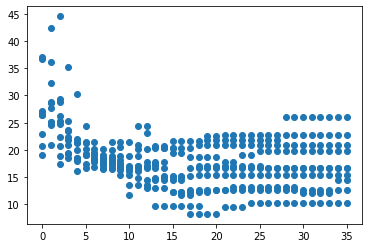

In [63]:
plt.scatter(epochs,COM_rev)
#plt.scatter([x for x in range(100)],COM_rev)

In [64]:
COM_split = []
for i in range(36):
    #COM_split.append(COM[i*10:(i+1)*10-3]+COM[(i+1)*10-2:(i+1)*10])
    COM_split.append(COM[i*10:(i+1)*10])

In [65]:
COM_split_rev = []
for i in range(36):
    #COM_split.append(COM[i*10:(i+1)*10-3]+COM[(i+1)*10-2:(i+1)*10])
    COM_split_rev.append(COM_rev[i*10:(i+1)*10])

In [66]:
import numpy as np
COM_split_np = np.array(COM_split)

In [67]:
COM_split_rev_np = np.array(COM_split_rev)

In [68]:
COM_line = np.mean(COM_split_np, axis=1)
COM_line.shape

(36,)

In [69]:
COM_line_rev = np.mean(COM_split_rev_np, axis=1)
COM_line_rev.shape

(36,)

In [262]:
epochs_cor[-10:]

[98, 99, 99, 99, 99, 99, 99, 99, 99, 99]

In [274]:
epochs = [x for x in range(100)]

In [240]:
len(epochs_cor)

900

In [296]:
epochs_cor = []
for i in range(100):
    epochs_cor+=epochs[i]

In [13]:
COM_split = np.array(COM_split)
COM_line = COM_line

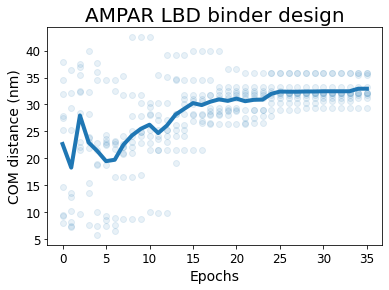

In [70]:
epochs_line = [x for x in range(36)]

plt.scatter(epochs, COM, alpha=0.1)
plt.plot(epochs_line, COM_line, linewidth=4)
plt.title('AMPAR LBD binder design', fontsize=20)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('COM distance (nm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('figs/AMPAR_LBD_5ybf_COM_change_100_10.jpg', dpi=800)
plt.show()

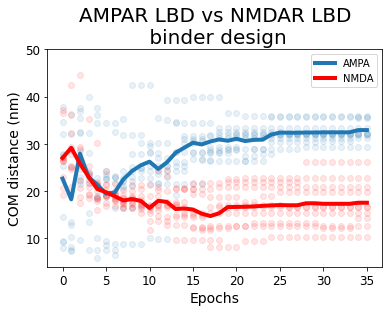

In [83]:
epochs_line = [x for x in range(36)]

plt.scatter(epochs, COM, alpha=0.1)
plt.plot(epochs_line, COM_line, linewidth=4, label='AMPA')
plt.scatter(epochs, COM_rev, alpha=0.1, c='r')
plt.plot(epochs_line, COM_line_rev, linewidth=4, c='r', label='NMDA')
plt.title('AMPAR LBD vs NMDAR LBD\n binder design', fontsize=20)
plt.legend()
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('COM distance (nm)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim((4,50))

plt.savefig('figs/AMPAR_LBD_5ybf_COM_change_100_10.jpg', dpi=800)
plt.show()

In [85]:
df['sequence'].tolist()[-10:]

['AVVAVARVYAAVRAAAAARV',
 'RAAARVRAVARVRAVAVVAV',
 'VAVVRAAVVVRARARARVAV',
 'AAAVAAVVRARARAAAAVAA',
 'AAAVAAAAAVRAAAVAAVRA',
 'VARVAARAVARVRAAAAAVV',
 'VYAVVAVVRAAARARAAAAV',
 'AVAAAAAAVVRAYARVRVAV',
 'RRRVVVVVVARARRAAAVAV',
 'RYRARAVVRVRVRAAAAVAV']

In [73]:
plt.plot(G_losses)

NameError: name 'G_losses' is not defined

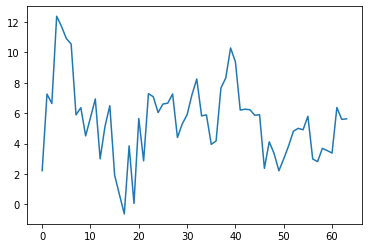

In [27]:
plt.plot(np.mean((np.array(COM_split_rev)-np.array(COM_split)), axis=1))


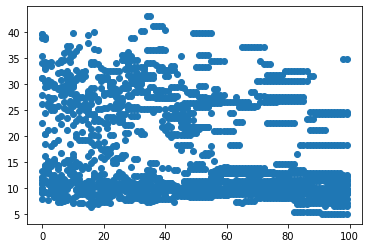

In [53]:
import matplotlib.pyplot as plt

plt.scatter(epochs, COM)

In [ ]:
list(netG.parameters())

In [131]:
fake_input = torch.randn(3, nz, 1, 1, device=device)
fake = netG(fake_input)

before = list(netG.parameters())

errG = criterion(torch.tensor([0.,1.]), torch.tensor([33., 0.98])).requires_grad_(True)
        # Calculate gradients for G

print(list(netG.parameters())[-2][0,0,0])

errF = criterion(torch.ones(fake.shape).to(device)*errG, fake)
errF.backward()
optimizerG.step()

#list(netG.parameters())[-2].grad = list(netG.parameters())[-2].data*0.1
#print(list(netG.parameters())[-2].grad[0,0,0])
#optimizerG.step()
print(list(netG.parameters())[-2][0,0,0])

    


tensor([-0.0024, -0.0072,  0.0241], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([-0.0029, -0.0079,  0.0235], device='cuda:0', grad_fn=<SelectBackward0>)


In [163]:
for i in list(netG.parameters()):
    print(i.shape)

torch.Size([100, 512, 5, 5])
torch.Size([512, 256, 5, 5])
torch.Size([256, 128, 4, 3])
torch.Size([128, 64, 4, 3])
torch.Size([64, 1, 4, 3])


In [198]:
with open('results/tmp_0_0.pickle', 'rb') as f:
    x = pickle.load(f)
print(np.mean(x['plddt'][0][-20:]))

0.40192994


In [332]:
with open('results/tmp_0_2_model_0_rank_1.pdb') as ifile:
      system = "".join([x for x in ifile])
system1 = system.split("\n")
system2 = []
for x in system1:
    if x[:4] == 'ATOM':
      system2.append(x)
CAS = [x for x in system2 if "CA" in x]
CAS = [x.split(' ') for x in CAS]
CAS = [[x for x in y if x!=''] for y in CAS ]
CAS_A = [x for x in CAS if x[4]=='B']
CAS_B = [x for x in CAS if x[4]=='A']
numbers_a = [13, 14, 21, 175, 179, 196, 200]

CAS_A = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_A])

CAS_B = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_B])

CAS_B = np.array([CAS_B[i-1] for i in numbers_a])

receptor_center = (sum([i for i in CAS_B]))/CAS_B.shape[0]
peptide_center = (sum([i for i in CAS_A]))/CAS_A.shape[0]
loss = sqrt(np.sum((peptide_center-receptor_center)**2))


In [333]:
CAS_A

array([[ 45.023, -19.187,  14.722],
       [ 42.318, -17.704,  16.715],
       [ 38.758, -18.582,  16.949],
       [ 35.857, -17.549,  18.449],
       [ 32.376, -17.406,  18.984],
       [ 28.635, -17.701,  18.887],
       [ 25.117, -18.112,  17.498],
       [ 22.266, -16.529,  19.454],
       [ 18.762, -18.25 ,  18.918],
       [ 16.086, -16.   ,  20.331],
       [ 12.795, -17.855,  20.324],
       [ 10.525, -15.683,  22.387],
       [  7.197, -14.037,  22.524],
       [  3.644, -14.922,  21.757],
       [  1.699, -12.002,  22.602],
       [ -1.306, -13.569,  24.452],
       [ -4.243, -11.723,  25.548],
       [ -7.805, -10.588,  25.042],
       [ -9.137,  -7.759,  27.115],
       [-12.591,  -6.354,  26.869]])

In [334]:
CAS_B

array([[  2.588,  -1.146,   6.838],
       [  6.19 ,  -2.204,   6.27 ],
       [ 12.295,  -0.394,  18.021],
       [  1.087, -10.858,   6.437],
       [  2.412, -16.704,   5.415],
       [  5.076,  -5.088,  -1.531],
       [  8.901,  -9.209,   0.792]])

In [339]:
from scipy.spatial import distance_matrix

np.min(distance_matrix(CAS_A, CAS_B))

15.244607636800627

In [336]:
receptor_center

array([ 5.507     , -6.51471429,  6.03457143])

In [335]:
peptide_center

array([ 15.2988 , -15.0756 ,  20.97635])